trying to understand basic cnn works as well as tensorboard
from 
- Conv2d layer
- MaxPooling
- * tensorboard

In [29]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('../../.tensor_board/data',
  # download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('../../.tensor_board/data',
   # download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Reimplemeting the CNN Model by implementing Conv2d from scratch


In [204]:
class Conv2d(nn.Module):
    # a poorman's conv2d layer(only forward pass tested). written just to understand how it works under the hood.
    def __init__(self, C_in, C_out, kernel_size):
        """
        B -> Batch size,
        C_out -> Number of output channels

        https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        """
        super(Conv2d, self).__init__()
        self.k = kernel_size
        self.C_out = C_out
        self.C_in = C_in
        self.weight = torch.nn.Parameter(torch.randn(C_out, C_in, kernel_size, kernel_size))
        self.bias = torch.nn.Parameter(torch.randn(C_out))
    def cross_correlation(self, inputs, weight, dim):
        # this can be replaced by np.correlate / scipy.ndimage.correlate, they are more efficient.
        # it uses fast fourier transform in its computation with is magnitude faster for larger arrays.
        
        res = torch.zeros(dim)
        
        for i in range(dim[0]): # height
            for j in range(dim[1]): # width 
                res[i,j] =  torch.sum(weight * inputs[i:i+self.k, j:j+self.k])
        return res # (H_out, W_out)
        
    def forward(self, input):
        # input -> (B, C_in, H_in, W_in)
        B = input.size(0)
        # Calculate the output dimensions
        H_out = input.size(-2) - self.k + 1
        W_out = input.size(-1) - self.k + 1
        
        ans = torch.zeros(B, self.C_out, H_out, W_out) # (B, C_out, H, W)
        for N_i in range(B):
            for C_out_j in range(self.C_out):
                cross_corr_sum = torch.zeros(H_out, W_out)
                for k in range(self.C_in):
                    c = self.cross_correlation(input[N_i, k], self.weight[C_out_j, k], dim=(H_out, W_out))
                    cross_corr_sum += c
                ans[N_i, C_out_j] = self.bias[C_out_j] + cross_corr_sum 
        return ans

net = Conv2d(1, 6, 3)
dd = net(torch.randn(4, 1, 10, 10))
print(dd.shape)

torch.Size([4, 6, 8, 8])


In [353]:
class MaxPool2d(nn.Module):
    # a poorman's MaxPool2d layer(only forward pass tested). written just to understand how it works under the hood.
    def __init__(self, kernel_size, stride):
        """
        https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d
        """
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
    def forward(self, inputs):
        B, C, H_in, W_in = inputs.shape
        # assuming stride is 1 on both B, C
        H_out = (H_in // self.kernel_size) 
        W_out = (W_in // self.kernel_size) 
        out = torch.zeros(B, C, H_out, W_out)
        for b in range(B):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        posh = h*self.stride
                        posw = w*self.stride
                        block = inputs[b, c, posh:posh+self.kernel_size, posw:posw+self.kernel_size]
                        # ans = block.reshape((-1,)).max(0)
                        # ans = block.max(dim=1, keepdim=True).values.max(dim=0, keepdim=True).values
                        out[b, c, h, w] = torch.max(block)
        return out

net = MaxPool2d(2, 2)
inp = torch.randn(2, 1, 16, 16, requires_grad=True)
orig = nn.MaxPool2d(2, 2)
# orig(inp) == net(inp)
torch.allclose(orig(inp), net(inp))
                

True

In [352]:
x = np.linspace(1, 5,5)
y = (np.random.randn(3) // 0.5) * 0.5
# cross-correlation, is just convolution without the flip of the kernel
corr, conv = np.correlate(x, y, mode="full"), np.convolve(x, np.flip(y))
print("corr/conv: ", corr, conv, np.all(corr == conv))

# it seems that output_size = input_size - kernel_size + 1


for i, data in enumerate(trainloader, 5): 
    inputs, labels = data
    print(i)
    print("input shape: ", inputs.shape)
    print("labels shape: ", labels.shape)
    conv = nn.Conv2d(1, 6, 5)
    print("original conv parameters: ", [i.shape for i in conv.parameters()])
    mine = Conv2d(1, 6, 5)
    mine.weight = conv.weight
    mine.bias = conv.bias
    print("my conv parameters: ", [i.shape for i in mine.parameters()])
    conv_out = conv(inputs)
    mine_out = mine(inputs)
    print("conv2d output shape: ", conv_out.shape, mine_out.shape)
    print("testing both: ", torch.allclose(conv_out, mine_out), torch.all(conv_out - mine_out < 1e-5).item()) # 💢
    # though all are not equal they are close at aproximate error of ~E=10^-5

    pool = nn.MaxPool2d(2,2)
    pool_out = pool(inputs)
    print("output from max pool shape: ", pool_out.shape)
    mine = MaxPool2d(2,2)
    mine_out = mine(inputs)
    print("my output from max pool shape: ", mine_out.shape)
    print("testing both: ", torch.allclose(pool_out, mine_out), torch.all(pool_out - mine_out < 1e-5).item()) # 💢
    break

corr/conv:  [-0.5 -0.5  0.   0.5  1.   4.5  2.5] [-0.5 -0.5  0.   0.5  1.   4.5  2.5] True
5
input shape:  torch.Size([4, 1, 28, 28])
labels shape:  torch.Size([4])
original conv parameters:  [torch.Size([6, 1, 5, 5]), torch.Size([6])]
my conv parameters:  [torch.Size([6, 1, 5, 5]), torch.Size([6])]
conv2d output shape:  torch.Size([4, 6, 24, 24]) torch.Size([4, 6, 24, 24])
testing both:  False True
output from max pool shape:  torch.Size([4, 1, 14, 14])
my output from max pool shape:  torch.Size([4, 1, 14, 14])
testing both:  True True


In [297]:
s = torch.randn(3, 10)
print(s)
s[0,0] = s.max(dim=1, keepdim=True).values.max(dim=0, keepdim=True).values
# s.max(dim=0)

tensor([[ 1.0138,  0.5590, -0.5872,  0.1536,  0.8506, -0.2311, -0.5321, -0.2137,
         -0.1066,  1.6171],
        [-0.3043, -0.4339,  1.6755,  1.1117,  0.7554,  1.3151, -0.6031, -0.6163,
          0.1046,  0.7804],
        [-0.9335,  0.2672,  0.5056, -0.5916, -0.6055,  2.3247, -1.2898, -2.7218,
          0.6508, -1.1789]])


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Set up Tensorboard

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../../.tensor_board/tmp/runs/fashion_mnist_experiment_cnn')

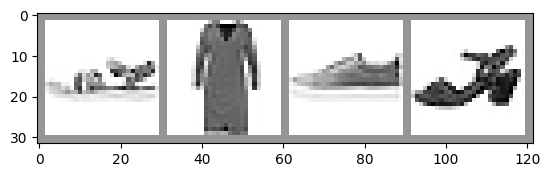

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [6]:
# Add model graph to tensorboard
writer.add_graph(net, images)

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
#writer.close()

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [10]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


In [11]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

In [17]:
total_params= sum(p.numel() for p in net.parameters())
print("total number of parameters:", total_params)
print("size in float32: ",(total_params * 4)/1e3, "KB")

total number of parameters: 44426
size in float32:  177.704 KB
